# Project

**Data Preparation**

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it

In [20]:
food_data = pd.read_csv('dec21pub.csv')

"Measures that combine information from multiple items (HRFS12M1 and following) are generally considered to be more reliable measures of food security and food insecurity" <br>

Maybe we want to drop predictors, as they are manipulations of the existing variables. Or explore VIF

In [21]:
list(food_data.columns).index('HRFS12M1')
#the 486th column of the data.

487

HRINTSTA informs whether or not the interview took place. We only want interviews that are complete!

In [22]:
#1's mean that the interview took place. Filter for this
#HRSUPINT 1's mean that the food security supplement survey took place. Filter for this too

food_data = food_data.loc[food_data['HRINTSTA']==1, :]
food_data = food_data.loc[food_data['HRSUPINT']==1,:]
food_data.shape

#these are households that completed the interview and the food security supplement survey. Ensuring no missing vals

(71571, 507)

In [23]:
#response variable: -5 indicates a missing val...
to_drop = list(food_data.loc[food_data['HRFS12CX']==-5, :].index) #38 vals were dropped here
food_data = food_data.drop(to_drop, axis=0)

In [24]:
#changing 1 and 2 to 0 and 1...does this matter though?
food_data['y'] = food_data['HRFS12CX'].apply(lambda x: 0 if 1 == x 
                                              else 1)
food_data.y.value_counts()

0    59124
1    12409
Name: y, dtype: int64

In [25]:
#splitting the data
y = food_data.y
X = food_data.iloc[:, 0:486]
X = X.drop('FILLER', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)
X_train.shape

(57226, 485)

In [26]:
train = pd.concat([X_train,y_train], axis=1)

# EDA

In [ ]:
food_data.iloc[:, 0:486].corrwith(food_data.y).sort_values(ascending = False)

HESS1       0.712532
HESH4       0.640454
HESH5       0.637635
HESH2       0.636681
HESH3       0.627601
              ...   
PULKPS4          NaN
PULKPS5          NaN
PULKPS6          NaN
HXPHONEO         NaN
HRSUPINT         NaN
Length: 486, dtype: float64

**The highest correlated survey questions include:** <br>
-In the last 12 months, did you ever eat lessthan you felt you should because there wasn't enough money for food? <br>
-Which of these statements best describes the food eaten in your household -- enough of the kinds of food (I/we) want to eat, enough but not always the kinds of food (I/we) want to eat, sometimes not enough to eat, or often not enough to eat? <br>
-In the last 12 months, did you lose weight because there wasn't enough money for food? <br>
-In the last 12 months did (you/you or other adults in your household) ever cut the size of your meals or skip meals because there wasn't enough money for food?

In [ ]:
np.corrcoef(food_data.HRPOOR, food_data.y)

array([[ 1.        , -0.47499814],
       [-0.47499814,  1.        ]])

<AxesSubplot:xlabel='HRPOOR', ylabel='y'>

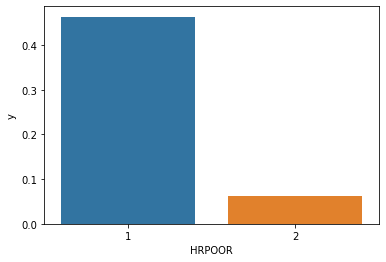

In [ ]:
sns.barplot(data = food_data, x = food_data.HRPOOR, y = food_data.y, ci = None)

<AxesSubplot:>

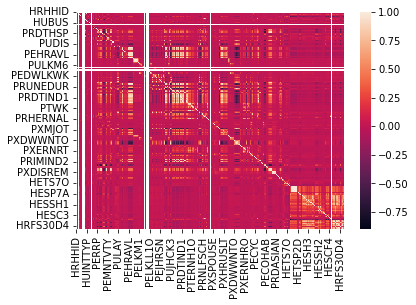

In [ ]:
sns.heatmap(food_data.corr())

# performing variable selection

basic random forest model

In [27]:
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1).fit(X_train, y_train)

In [30]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in model.estimators_
], axis=0)
importances = list(feature_importances)
cols = []
for i in importances:
    if i > 0.0000000001:
        cols.append(importances.index(i))
len(cols)
feature_importances

array([5.70021663e-03, 0.00000000e+00, 0.00000000e+00, 1.42731868e-03,
       5.47840009e-04, 1.40575842e-03, 8.43648213e-04, 2.55684076e-04,
       4.80302319e-04, 6.01054359e-04, 1.20479871e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.82038557e-03, 0.00000000e+00,
       3.11104439e-03, 1.81075861e-03, 3.04302371e-03, 1.31846769e-03,
       1.58370230e-03, 1.17717784e-03, 2.11548465e-03, 1.21341908e-03,
       5.64482232e-04, 7.43889562e-04, 2.35125202e-04, 3.26944233e-05,
       0.00000000e+00, 1.87752821e-03, 3.13477489e-03, 4.51112956e-03,
       4.61394182e-03, 2.79772495e-03, 1.79940286e-03, 8.44388903e-04,
       9.93736310e-04, 2.49156575e-03, 2.64892901e-03, 1.14195782e-03,
       3.13315075e-03, 1.63774704e-04, 9.08589109e-04, 6.01304031e-04,
       4.56197784e-04, 2.67978517e-04, 5.54607950e-05, 1.82661713e-03,
       1.64228501e-03, 1.25801882e-03, 3.50392688e-04, 8.89015467e-04,
       6.16365089e-04, 9.07738274e-04, 8.11638083e-04, 7.22629557e-04,
      

In [32]:
importances_data = pd.concat([pd.Series(model.feature_names_in_), pd.Series(importances)], axis = 1, keys = ['predictor','importance'])
importances_data.sort_values(by = ['importance'], ascending = False)


,predictor,importance
428,HESS1,0.128431
405,HES9,0.079692
439,HESH3,0.043638
435,HESH2,0.041798
447,HESH5,0.041684
...,...,...
134,PULKPS4,0.000000
133,PULKPS3,0.000000
132,PULKPS2,0.000000
130,PULKDK6,0.000000


Attempting stepwise selection:

In [ ]:
import statsmodels.api as sm

def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('y~' + '+'.join(predictor_subset),data = train).fit()
    log_like = model.llf
    return {"model":model, "log_likelihood":log_like}



In [ ]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    return models_best

In [ ]:
models_best = forward_selection()

NameError: name 'sm' is not defined

In [ ]:
best_sub_plots()

# Model Development: AdaBoost

>10 1.000 (0.001)
>50 1.000 (0.000)
>100 1.000 (0.000)
>500 1.000 (0.000)
>1000 1.000 (0.000)
>5000 1.000 (0.000)


Text(0.5, 0, 'Number of trees')

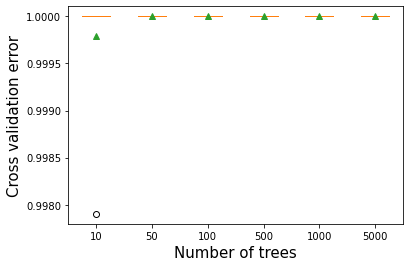

In [ ]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)